# Imports

In [1]:
!pip install ipywidgets  -q
from google.colab import output
output.enable_custom_widget_manager()

import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, FloatSlider, fixed, Layout

from IPython.display import display, Image

# Photoconversion rates

For BphP1 conversion rates, I'm using Figure 1b from [Kaberniuk et al.](https://www.ncbi.nlm.nih.gov/core/lw/2.0/html/tileshop_pmc/tileshop_pmc_inline.html?title=Click%20on%20image%20to%20zoom&p=PMC3&id=4927390_nihms778522f1.jpg) to estimate the conversion rate of Pfr to Pr, given a wavelength.

For CRY2 conversion rates, I'm using an absorption curve as an approximation for the photoconversion rate.

In [2]:
!wget https://raw.githubusercontent.com/jen-baek/red-blue-and-gate/main/bphp1_conversion.csv -q
!wget https://raw.githubusercontent.com/jen-baek/red-blue-and-gate/main/cry2_conversion.csv -q

lambda_min, lambda_max = (300, 800)

df_bphp1 = pd.read_csv('bphp1_conversion.csv')
df_cry2 = pd.read_csv('cry2_conversion.csv')

red_interp = interp1d(df_bphp1['X'].tolist(), df_bphp1['Y'].tolist(),
                      kind='cubic', bounds_error=False, fill_value='extrapolate')
blue_interp = interp1d(df_cry2['X'].tolist(), df_cry2['Y'].tolist(),
                      kind='cubic', bounds_error=False, fill_value=0)

x_red = np.arange(lambda_min, lambda_max, 5)
y_red = red_interp(x_red)
x_blue = np.arange(lambda_min, lambda_max, 5)
y_blue = blue_interp(x_blue)

Check that the interpolation matches the data.

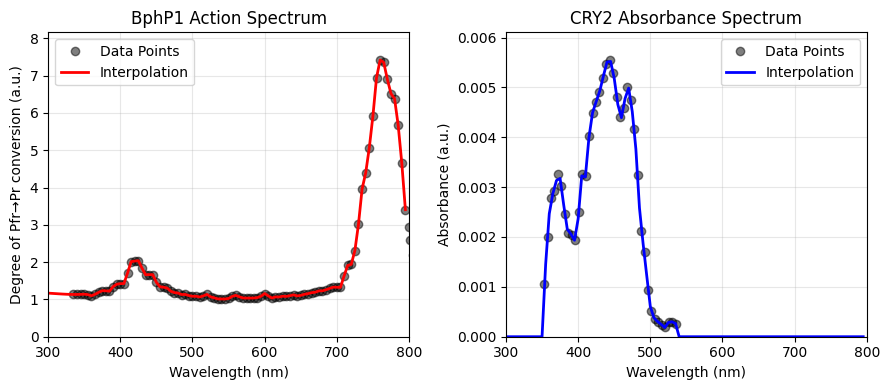

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

# BphP1
ax1.plot(df_bphp1['X'], df_bphp1['Y'], 'o', label='Data Points', color='black', alpha=0.5)
ax1.plot(x_red, y_red, '-', label='Interpolation', color='r', linewidth=2)
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Degree of Pfr→Pr conversion (a.u.)')
ax1.set_title('BphP1 Action Spectrum')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(lambda_min, lambda_max)
ax1.set_ylim(0, max(df_bphp1['Y']) * 1.1)

# CRY2
ax2.plot(df_cry2['X'], df_cry2['Y'], 'o', label='Data Points', color='black', alpha=0.5)
ax2.plot(x_blue, y_blue, '-', label='Interpolation', color='b', linewidth=2)
ax2.set_xlabel('Wavelength (nm)')
ax2.set_ylabel('Absorbance (a.u.)')
ax2.set_title('CRY2 Absorbance Spectrum')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(lambda_min, lambda_max)
ax2.set_ylim(0, max(df_cry2['Y']) * 1.1)

plt.tight_layout()
plt.show()

Normalize both interpolations so the Y-values are between 0.0 and 1.0.

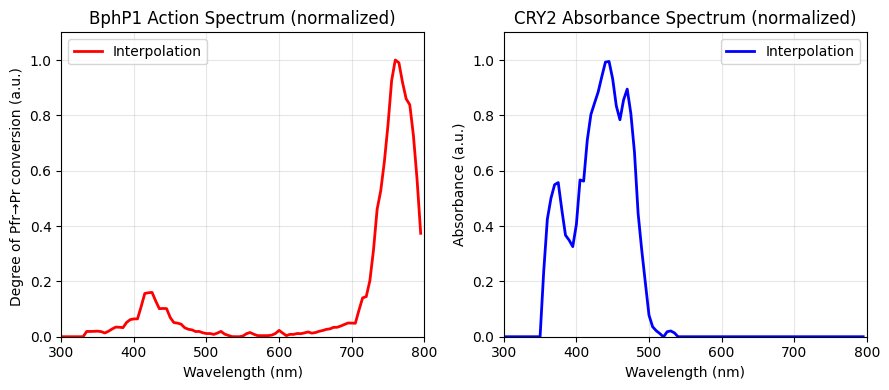

In [4]:
y_bphp1_norm = ((df_bphp1['Y'] - df_bphp1['Y'].min()) / (df_bphp1['Y'].max() - df_bphp1['Y'].min())).tolist()
y_cry2_norm = ((df_cry2['Y'] - df_cry2['Y'].min()) / (df_cry2['Y'].max() - df_cry2['Y'].min())).tolist()

red_interp_norm = interp1d(df_bphp1['X'].tolist(), y_bphp1_norm,
                      kind='cubic', bounds_error=False, fill_value=0)
blue_interp_norm = interp1d(df_cry2['X'].tolist(), y_cry2_norm,
                      kind='cubic', bounds_error=False, fill_value=0)

y_red_norm = red_interp_norm(x_red)
y_blue_norm = blue_interp_norm(x_blue)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

# BphP1
ax1.plot(x_red, y_red_norm, '-', label='Interpolation', color='r', linewidth=2)
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Degree of Pfr→Pr conversion (a.u.) ')
ax1.set_title('BphP1 Action Spectrum (normalized)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(lambda_min, lambda_max)
ax1.set_ylim(0, max(y_bphp1_norm) * 1.1)

# CRY2
ax2.plot(x_blue, y_blue_norm, '-', label='Interpolation', color='b', linewidth=2)
ax2.set_xlabel('Wavelength (nm)')
ax2.set_ylabel('Absorbance (a.u.)')
ax2.set_title('CRY2 Absorbance Spectrum (normalized)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(lambda_min, lambda_max)
ax2.set_ylim(0, max(y_cry2_norm) * 1.1)

plt.tight_layout()
plt.show()

In [18]:
def calculate_k_red(lambda1):
    '''
    np.log(2) / (19/60) = photoconversion half-life for BphP1 at 740nm
    '''
    k_red = (np.log(2) / (19/60)) * red_interp_norm(lambda1)
    return k_red

def calculate_k_blue(lambda2):
    '''
    np.log(2) / (5/60) = photoconversion half-life for BphP1 at 740nm
    '''
    k_blue = (np.log(2) / (5/60)) * blue_interp_norm(lambda2)
    return k_blue

# Constants

In [13]:
k_red_reverse = np.log(2) / (210/60)  # Time rate for Pr -> Pfr
k_blue_reverse = np.log(2) / (12.5/60)  # Time rate for CRY2 to become inactive
k_YFP = 10  # Max YFP production rate

# Protein degradation
deg_BphP1 = 0.005
deg_CRY2 = 0.005
deg_hdimer = 0.005
deg_YFP = 0.005

# Total concentration of BphP1 and CRY2
BphP1_total = 4
CRY2_total = 4

# Binding
k_bind = 0.1
k_unbind = 0.05

n = 3  # Hill coefficient
K = 1.0

## ODE Model Function - d(YFP)/dt

In [7]:
def ode_model(state, t, k_red, k_blue):
    '''
    Returns d(YFP)/dt.
    '''

    # Setting intensities constant for now - change this later!
    I_red = 1.0
    I_blue = 1.0

    [BphP1_Pr, CRY2_active, hdimer, YFP] = state

    BphP1_Pfr = BphP1_total - BphP1_Pr
    CRY2_inactive = CRY2_total - CRY2_active

    d_BphP1_Pr = (k_red * I_red * BphP1_Pfr) - (k_red_reverse * BphP1_Pr) - (deg_BphP1 * BphP1_total) - (k_bind * BphP1_Pr * CRY2_active) + (k_unbind * hdimer)
    d_CRY2_active = (k_blue * I_blue * CRY2_inactive) - (k_blue_reverse * CRY2_active) - (deg_CRY2 * CRY2_total) - (k_bind * BphP1_Pr * CRY2_active) + (k_unbind * hdimer)
    d_hdimer = (k_bind * BphP1_Pr * CRY2_active) - (k_unbind * hdimer) - (deg_hdimer * hdimer)
    d_YFP = k_YFP * (hdimer ** n / (K ** n + hdimer ** n)) - deg_YFP * YFP

    return [d_BphP1_Pr, d_CRY2_active, d_hdimer, d_YFP]

# Interactive Simulation

In [8]:
def what_color_is_it(wavelength):
    color = ''
    if (380 <= wavelength <= 445):
        color = 'violet'
    elif (445 < wavelength <= 475):
        color = 'blue'
    elif (475 < wavelength <= 510):
        color = 'cyan'
    elif (510 < wavelength <= 570):
        color = 'green'
    elif (570 < wavelength <= 590):
        color = 'yellow'
    elif (590 < wavelength <= 650):
        color = 'orange'
    elif (650 < wavelength <= 780):
        color = 'red'
    else:
        color = 'N/A'
    return color

In [16]:
def simulate(lambda1, lambda2, initial_state=[0.0, 0.0, 0.0], t_max=2000):

    # We can do this because there's very little overlap between the
    # absorption spectra for BphP1 and CRY2! e.g. they don't compete
    k_red = calculate_k_red(lambda1) + calculate_k_red(lambda2)
    k_blue = calculate_k_blue(lambda1) + calculate_k_blue(lambda2)

    print(f"DEBUG: k_red = {k_red:.6f}, k_blue = {k_blue:.6f}")
    print(f"  k_red from λ1={lambda1}: {calculate_k_red(lambda1):.6f}")
    print(f"  k_red from λ2={lambda2}: {calculate_k_red(lambda2):.6f}")
    print(f"  k_blue from λ1={lambda1}: {calculate_k_blue(lambda1):.6f}")
    print(f"  k_blue from λ2={lambda2}: {calculate_k_blue(lambda2):.6f}")

    t = np.arange(0, t_max)

    solution = odeint(ode_model, initial_state, t, args=(k_red, k_blue))

    BphP1_Pr = solution[:, 0]
    CRY2_active = solution[:, 1]
    YFP = solution[:, 2]

    # PLOTTING

    plt.style.use('dark_background')
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(f'λ1 = {lambda1:.0f} nm ({what_color_is_it(lambda1)}), λ2 = {lambda2:.0f} nm ({what_color_is_it(lambda2)})',
                 fontsize=14, fontweight='bold')

    # BphP1
    axes[0].plot(t, BphP1_Pr, '-', color='#F52727', linewidth=2)
    axes[0].set_xlabel('Time (hours)')
    axes[0].set_ylabel('BphP1 Pr (μM)')
    axes[0].set_title(f'BphP1 - Absorption range')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(0, 35)

    # CRY2
    axes[1].plot(t, CRY2_active, '-', color='#27EEF5', linewidth=2)
    axes[1].set_xlabel('Time (hours)')
    axes[1].set_ylabel('CRY2 Active (μM)')
    axes[1].set_title(f'CRY2 - Absorption range')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim(0, 35)

    # YFP
    axes[2].plot(t, YFP, '-', color='gold', linewidth=2)
    axes[2].set_xlabel('Time (minutes)')
    axes[2].set_ylabel('YFP (μM)')
    axes[2].set_title(f'YFP Output (Final: {YFP[-1]:.2f})')
    axes[2].grid(True, alpha=0.3)
    axes[2].set_ylim(0, 35)

    plt.tight_layout()
    plt.show()

    plt.style.use('default')
    print(f"Final YFP concentration: {YFP[-1]:.3f} μM")

In [19]:
INIT_STATE = [0.0, 0.0, 0.0, 0.0]
MAX_TIME = 2000

display(Image(url='https://i.sstatic.net/GUzkd.png', width=800))

interact(simulate,
         lambda1=FloatSlider(min=380,
                             max=780,
                             step=1,
                             value=760,
                             description='Wavelength 1',
                             layout=Layout(width='840px')),
         lambda2=FloatSlider(min=380,
                             max=780,
                             step=1,
                             value=450,
                             description='Wavelength 2',
                             layout=Layout(width='840px')),
         initial_state=fixed(INIT_STATE),
         t_max=fixed(MAX_TIME))

interactive(children=(FloatSlider(value=760.0, description='Wavelength 1', layout=Layout(width='840px'), max=7…

<function __main__.simulate(lambda1, lambda2, initial_state=[0.0, 0.0, 0.0], t_max=2000)>